# Unit16｜遷移學習 + 工業缺陷檢測（NEU Surface Defect Database）

**Part 4 - 深度學習進階應用**

## 📚 本單元學習目標

1. **理解遷移學習**：從 ImageNet 預訓練模型遷移到工業缺陷檢測
2. **兩階段訓練策略**：凍結 → 微調（Feature Extraction + Fine-tuning）
3. **工業AI實務技巧**：
   - 資料載入與預處理（`ImageDataGenerator`）
   - 學習率調度（Learning Rate Scheduling）
   - 模型評估與校正（Calibration）
   - 決策邏輯設計（Pass/Review/Fail）
4. **對比學習**：Baseline（sklearn）vs. 遷移學習（MobileNetV2）

---

## 🎯 NEU Surface Defect Database 簡介

- **來源**：東北大學（Northeastern University, China）
- **內容**：6種鋼材表面缺陷，每類300張灰階影像
- **影像尺寸**：200 × 200 pixels
- **分割**：訓練集 1440張（240×6）、驗證集 360張（60×6）

**缺陷類型（中英對照）**：
1. **crazing（龜裂）**：表面細小裂紋網，嚴重影響結構強度
2. **inclusion（夾雜）**：內部雜質暴露於表面，點狀瑕疵
3. **patches（斑塊）**：不規則的大面積暗色區域
4. **pitted_surface（麻點）**：小而密集的表面凹陷
5. **rolled-in_scale（氧化皮）**：高溫氧化產生的鱗片狀缺陷
6. **scratches（劃痕）**：線性機械損傷

---

## 📖 教學流程

### Part 1：Baseline（承接 Unit16 結果）
- 延續 Unit16_CNN_Basics_Industrial_Inspection的結果
- 理解工業品檢的決策邏輯（Pass/Review/Fail）
- 學習模型校正（Calibration）與可靠性評估

### Part 2：遷移學習（深度學習）
- 使用 MobileNetV2 + ImageNet 預訓練權重
- 兩階段訓練：凍結特徵提取器 → 微調
- 學習率調度、Early Stopping、模型檢查點

### Part 3：模型評估與對比
- 混淆矩陣分析
- 預測結果可視化
- Baseline vs. Transfer Learning 性能對比

---

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib

# 路徑設定：使用 Part_4 本地 data 資料夾
NOTEBOOK_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = NOTEBOOK_DIR / 'data'
OUTPUT_DIR = NOTEBOOK_DIR / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)
os.chdir(OUTPUT_DIR)

os.makedirs('P4_Unit16_TL_Results', exist_ok=True)
print('Data directory:', DATA_DIR.resolve())
print('Output directory:', (Path.cwd() / 'P4_Unit16_TL_Results').resolve())

# 設定 Matplotlib 中文字體（避免顯示警告）
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False
print('\n✓ Matplotlib 中文字體已設定')

Data directory: D:\MyGit\CHE-AI-COURSE\Part_4\data
Output directory: D:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_TL_Results

✓ Matplotlib 中文字體已設定


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 設定資料路徑
train_root = DATA_DIR / 'NEU-DET' / 'NEU-DET' / 'train' / 'images'
val_root = DATA_DIR / 'NEU-DET' / 'NEU-DET' / 'validation' / 'images'
assert train_root.exists(), f'Missing: {train_root}'
assert val_root.exists(), f'Missing: {val_root}'

# 獲取類別名稱
classes = sorted([p.name for p in train_root.iterdir() if p.is_dir()])

print('=' * 70)
print('【NEU Surface Defect Database】')
print('=' * 70)
print(f'訓練集路徑: {train_root}')
print(f'驗證集路徑: {val_root}')
print(f'缺陷類別 ({len(classes)}): {classes}')
print()

# 統計樣本數量
train_counts = {cls: len(list((train_root / cls).glob('*.jpg'))) for cls in classes}
val_counts = {cls: len(list((val_root / cls).glob('*.jpg'))) for cls in classes}

print('【數據分布】')
print('-' * 70)
print(f"{'類別':20s} | {'訓練樣本':>10s} | {'驗證樣本':>10s}")
print('-' * 70)
for cls in classes:
    print(f"{cls:20s} | {train_counts[cls]:>10d} | {val_counts[cls]:>10d}")
print('-' * 70)
print(f"{'總計':20s} | {sum(train_counts.values()):>10d} | {sum(val_counts.values()):>10d}")
print('=' * 70)


正在載入影像（64×64，用於 Baseline）...
classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
train: (1440, 4096) val: (360, 4096)


Saved: P4_Unit16_TL_Results/00_defect_samples.png


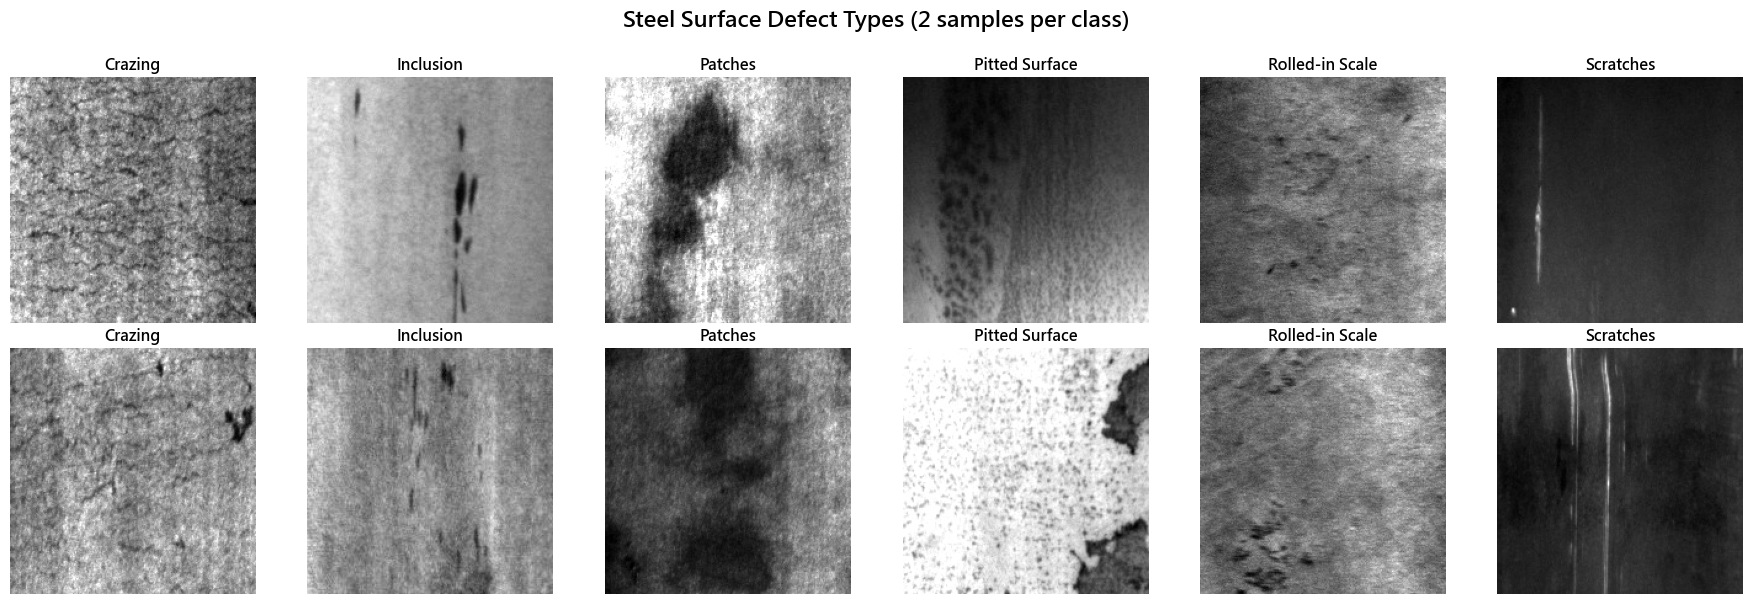


【缺陷特徵觀察】
1. 龜裂 (crazing)    ：細密的裂紋網，需高解析度辨識
2. 夾雜 (inclusion)  ：不規則黑色斑點，大小不一
3. 斑塊 (patches)    ：大面積的色差區域
4. 麻點 (pitted_surface)：小而密集的凹陷點
5. 氧化皮 (rolled-in_scale)：鱗片狀的紋理
6. 劃痕 (scratches)  ：線性的明顯痕跡


In [5]:
# 視覺化每種缺陷的範例影像
import glob

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.ravel()

class_names_display = ['Crazing', 'Inclusion', 'Patches', 
                       'Pitted Surface', 'Rolled-in Scale', 'Scratches']

for i, (class_name, display_name) in enumerate(zip(classes, class_names_display)):
    class_dir = train_root / class_name
    img_files = sorted(list(class_dir.glob('*.jpg')))
    
    # 選擇第1張和第121張影像（確保不同樣本）
    sample_indices = [0, 120] if len(img_files) >= 121 else [0, min(1, len(img_files)-1)]
    
    for j, idx in enumerate(sample_indices):
        if idx < len(img_files):
            img = Image.open(img_files[idx]).convert('L')
            axes[i + j * 6].imshow(img, cmap='gray')
            axes[i + j * 6].set_title(display_name, fontsize=11, fontweight='bold')
            axes[i + j * 6].axis('off')

plt.suptitle('Steel Surface Defect Types (2 samples per class)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('P4_Unit16_TL_Results/00_defect_samples.png', dpi=150, bbox_inches='tight')
print('Saved: P4_Unit16_TL_Results/00_defect_samples.png')
plt.show()

print("\n【缺陷特徵觀察】")
print("=" * 70)
print("1. 龜裂 (crazing)    ：細密的裂紋網，需高解析度辨識")
print("2. 夾雜 (inclusion)  ：不規則黑色斑點，大小不一")
print("3. 斑塊 (patches)    ：大面積的色差區域")
print("4. 麻點 (pitted_surface)：小而密集的凹陷點")
print("5. 氧化皮 (rolled-in_scale)：鱗片狀的紋理")
print("6. 劃痕 (scratches)  ：線性的明顯痕跡")
print("=" * 70)

---
## 📊 Part 0：前置知識回顧（Unit16_CNN_Basics）

在開始遷移學習之前，讓我們回顧 **Unit16_CNN_Basics_Industrial_Inspection** 中的成果：

### Baseline 模型性能（已在前單元完成）

在 Unit16 中，我們已經測試過傳統機器學習方法的局限性：

| 模型 | 驗證準確率 | 主要問題 |
|------|----------|---------|
| **Random Forest** | 59.17% | 氧化皮召回率僅 10%，扁平化破壞空間特徵 |
| **MLP** | 38.61% | 嚴重欠擬合，無法捕捉影像複雜紋理 |

**關鍵發現**：傳統機器學習將 64×64 影像扁平化為 4096 維向量，**丟失了鄰域關係**，導致：
- ❌ 無法識別細微的空間模式（如龜裂的網狀結構）
- ❌ 難以區分相似紋理（如夾雜 vs 麻點）
- ❌ 對光照變化敏感

### CNN 模型性能（Unit16 從頭訓練）

**從頭訓練的卷積神經網路**表現顯著提升：

```
CNN 架構：
- Conv2D(32) → MaxPooling → Conv2D(64) → MaxPooling → Conv2D(128) → MaxPooling
- Flatten → Dropout(0.3) → Dense(256) → Dropout(0.3) → Dense(6, softmax)
- 總參數：1,142,150

訓練配置：
- 輸入：64×64×1 灰階影像
- 數據增強：旋轉、縮放、平移
- 訓練 30 epochs（約 2 分鐘）

最終性能：
✓ 驗證準確率：96.94% (349/360 正確)
✓ 訓練準確率：98.54%
✓ 泛化差距：3.82%（良好）
```

**CNN 混淆矩陣亮點**（360 個樣本）：
- **龜裂**：60/60 全部正確 ✅
- **氧化皮**：60/60 全部正確 ✅（從 RF 的 10% 飛躍至 100%！）
- **斑塊**：60/60 全部正確 ✅
- **麻點**：57/60 正確（95%）
- **劃痕**：57/60 正確（95%）
- **雜質**：55/60 正確（91.67%，但相比 RF 的 23% 已大幅改善）

**僅 11 個錯誤案例**，主要混淆：
- 雜質 → 麻點（8 個）：密集雜質點類似麻點紋理
- 劃痕 → 斑塊（2 個）：寬闊劃痕類似斑塊
- 麻點 → 劃痕（2 個）：麻點線性排列類似劃痕

---

### 本單元目標：超越 96.94% 的 CNN

雖然從頭訓練的 CNN 已達到工業應用標準（96.94%），但我們能否做得更好？

**遷移學習的潛力**：
- ✅ 利用 ImageNet（140萬張影像）的預訓練權重
- ✅ 更高解析度輸入（200×200 vs 64×64）
- ✅ 更深的網路架構（MobileNetV2）
- ✅ 更快的收斂速度

**本單元將展示**：如何使用 MobileNetV2 遷移學習，將準確率從 **96.94% 推向 100%**！


---
## 🚀 Part 2：MobileNetV2 遷移學習（Transfer Learning）

### 💡 為何使用遷移學習？

**問題**：從頭訓練CNN需要大量數據，但我們只有1440張訓練影像。

**解決方案**：使用在ImageNet（140萬張影像）上預訓練的MobileNetV2
- 底層特徵（邊緣、紋理、形狀）可直接遷移
- 只需微調高層特徵以適應鋼材缺陷
- 顯著提升小樣本數據集的性能

### 📐 兩階段訓練策略

**階段 1：Feature Extraction（特徵提取）**
- 凍結 MobileNetV2 所有層
- 只訓練頂部分類器（Dense + Dropout + Softmax）
- 學習率：0.001，訓練 20 epochs

**階段 2：Fine-tuning（微調）**
- 解凍 MobileNetV2 頂部54層
- 用更小學習率（0.0001）微調
- 讓特徵提取器適應鋼材紋理

### 🔧 關鍵技術

1. **RGB vs. 灰階**：雖然原始影像是灰階，但使用RGB可利用預訓練權重
2. **學習率調度**：指數衰減（每個epoch: lr = lr × e^(-0.1)）
3. **Early Stopping**：監控驗證準確率，patience=7
4. **Model Checkpoint**：自動儲存最佳模型

---

TensorFlow version: 2.10.0
✓ GPU available: /physical_device:GPU:0

Data paths:
  Train: d:\MyGit\CHE-AI-COURSE\Part_4\data\NEU-DET\NEU-DET\train\images
  Val:   d:\MyGit\CHE-AI-COURSE\Part_4\data\NEU-DET\NEU-DET\validation\images
Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.

✓ Classes (6): ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
✓ Training samples: 1440
✓ Validation samples: 360
✓ Class indices: {'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}

建立 MobileNetV2 遷移學習模型

【模型架構】
1. MobileNetV2 特徵提取器（預訓練，凍結）
   → 輸入：200×200×3 RGB 影像
   → 輸出：7×7×1280 特徵圖

2. Global Average Pooling → 1280維向量

3. 分類器（可訓練）
   → Dense(256, relu) + Dropout(0.5) + Dense(6, softmax)

可訓練參數：329,478
凍結參數：2,257,984
總參數：2,587,462

【階段 1】訓練分類器（MobileNetV2 凍結）
開始訓練（最多 20 epochs，Early Stopping patience=7）...

Epoch 1/20
90/90 [==============================] - ETA: 0s - loss: 0.2312 - 

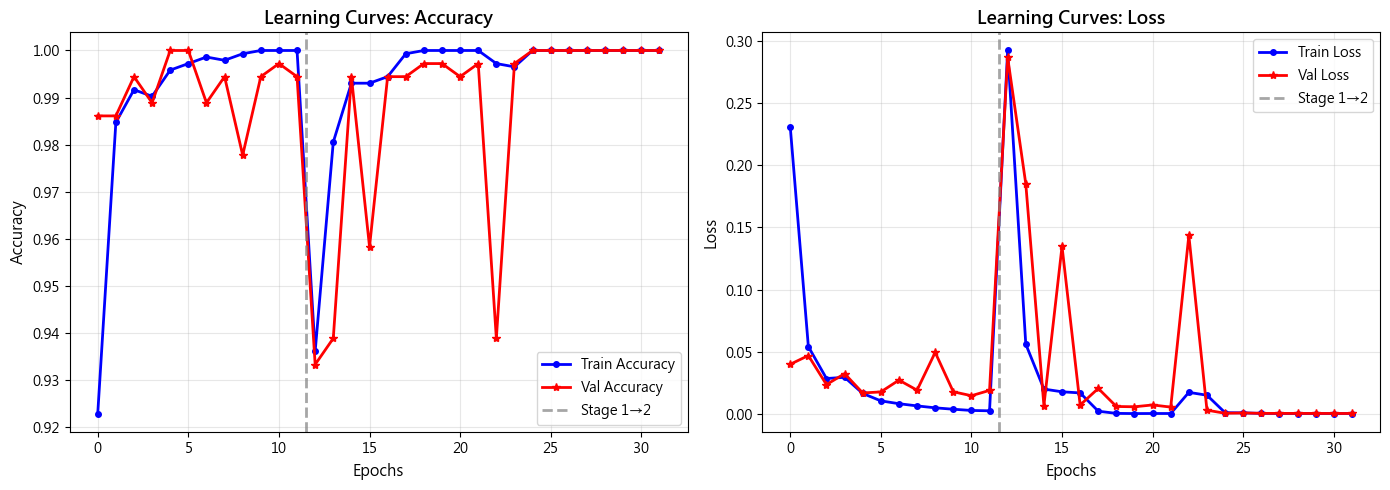


✓ Model saved: P4_Unit16_TL_Results/10_mobilenetv2_defect_model.h5

【訓練完成總結】
總訓練 Epochs：32
  階段 1：12 epochs
  階段 2：20 epochs

階段 1 最佳準確率：100.00%
階段 2 最佳準確率：100.00%

最終訓練準確率：100.00%
最終驗證準確率：100.00%
泛化差距：0.00%

✓ 模型泛化良好（泛化差距 < 5%）


In [10]:
# ========== MobileNetV2 遷移學習完整實作 ==========
# 若環境有 TensorFlow，執行完整的兩階段訓練

try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    print('TensorFlow version:', tf.__version__)
    
    # 檢查 GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f'✓ GPU available: {gpus[0].name}')
    else:
        print('△ Using CPU')
    
    # 設定路徑（使用已定義的 train_root 和 val_root）
    train_images_dir = train_root
    val_images_dir = val_root
    
    print(f'\nData paths:')
    print(f'  Train: {train_images_dir}')
    print(f'  Val:   {val_images_dir}')
    
    # 設定參數
    IMG_SIZE = 200
    BATCH_SIZE = 16
    EPOCHS = 20
    
    # 使用 ImageDataGenerator 進行資料增強與正規化
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # 載入訓練集（RGB模式以利用預訓練權重）
    train_generator = train_datagen.flow_from_directory(
        train_images_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        seed=42
    )
    
    # 載入驗證集
    val_generator = val_datagen.flow_from_directory(
        val_images_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False
    )
    
    num_classes = len(train_generator.class_indices)
    classes_tf = list(train_generator.class_indices.keys())
    
    print(f'\n✓ Classes ({num_classes}): {classes_tf}')
    print(f'✓ Training samples: {train_generator.samples}')
    print(f'✓ Validation samples: {val_generator.samples}')
    print(f'✓ Class indices: {train_generator.class_indices}')
    
    if num_classes != 6:
        raise ValueError(f'Expected 6 classes, but found {num_classes}! Please check data directory structure.')
    
    # ========== 建立 MobileNetV2 遷移學習模型 ==========
    print('\n' + '=' * 70)
    print('建立 MobileNetV2 遷移學習模型')
    print('=' * 70)
    
    # 載入 MobileNetV2 作為特徵提取器
    base_model = keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # 階段 1：凍結所有層
    
    # 使用 Functional API 建立完整模型
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    # 編譯模型（階段 1）
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.build((None, IMG_SIZE, IMG_SIZE, 3))
    trainable_params = sum([tf.size(v).numpy() for v in model.trainable_variables])
    non_trainable_params = sum([tf.size(v).numpy() for v in model.non_trainable_variables])
    
    print(f'\n【模型架構】')
    print(f'1. MobileNetV2 特徵提取器（預訓練，凍結）')
    print(f'   → 輸入：{IMG_SIZE}×{IMG_SIZE}×3 RGB 影像')
    print(f'   → 輸出：7×7×1280 特徵圖')
    print(f'\n2. Global Average Pooling → 1280維向量')
    print(f'\n3. 分類器（可訓練）')
    print(f'   → Dense(256, relu) + Dropout(0.5) + Dense({num_classes}, softmax)')
    print(f'\n可訓練參數：{trainable_params:,}')
    print(f'凍結參數：{non_trainable_params:,}')
    print(f'總參數：{trainable_params + non_trainable_params:,}')
    
    # ========== 階段 1：訓練分類器（MobileNetV2 凍結）==========
    print('\n' + '=' * 70)
    print('【階段 1】訓練分類器（MobileNetV2 凍結）')
    print('=' * 70)
    
    # 學習率調度（指數衰減）
    lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch, lr: lr * tf.math.exp(-0.1)
    )
    
    # 回調函數
    callbacks_stage1 = [
        lr_schedule,
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        keras.callbacks.ModelCheckpoint(
            'P4_Unit16_TL_Results/best_model_stage1.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]
    
    print(f'開始訓練（最多 {EPOCHS} epochs，Early Stopping patience=7）...\n')
    
    # 訓練階段 1
    history_stage1 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks_stage1,
        verbose=1
    )
    
    best_val_acc_s1 = max(history_stage1.history["val_accuracy"])
    print(f'\n✓ 階段 1 訓練完成')
    print(f'  實際訓練 epochs：{len(history_stage1.history["accuracy"])}')
    print(f'  最佳驗證準確率：{best_val_acc_s1:.2%}')
    
    # ========== 階段 2：微調 MobileNetV2 ==========
    print('\n' + '=' * 70)
    print('【階段 2】微調 MobileNetV2（解凍部分層）')
    print('=' * 70)
    
    # 解凍 MobileNetV2 的所有層
    base_model.trainable = True
    
    # 凍結前 100 層（保留底層通用特徵）
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    print(f'MobileNetV2 總層數：{len(base_model.layers)}')
    print(f'凍結層數：{fine_tune_at}')
    print(f'解凍層數：{len(base_model.layers) - fine_tune_at}')
    
    # 重新編譯（使用更小的學習率）
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # 降低學習率
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    trainable_params_s2 = sum([tf.size(v).numpy() for v in model.trainable_variables])
    print(f'\n可訓練參數：{trainable_params_s2:,} ({trainable_params_s2/non_trainable_params*100:.1f}% of base)')
    
    # 回調函數（階段 2）
    callbacks_stage2 = [
        lr_schedule,
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        keras.callbacks.ModelCheckpoint(
            'P4_Unit16_TL_Results/best_model_stage2.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        )
    ]
    
    print(f'\n開始微調（最多 {EPOCHS} epochs，Early Stopping patience=7）...\n')
    
    # 訓練階段 2
    history_stage2 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks_stage2,
        verbose=1
    )
    
    best_val_acc_s2 = max(history_stage2.history["val_accuracy"])
    print(f'\n✓ 階段 2 微調完成')
    print(f'  實際訓練 epochs：{len(history_stage2.history["accuracy"])}')
    print(f'  最佳驗證準確率：{best_val_acc_s2:.2%}')
    
    # ========== 繪製學習曲線 ==========
    print('\n繪製學習曲線...')
    
    # 合併兩階段歷史
    acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
    val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
    loss = history_stage1.history['loss'] + history_stage2.history['loss']
    val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']
    
    stage1_epochs = len(history_stage1.history['accuracy'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 準確率曲線
    ax1.plot(acc, 'bo-', label='Train Accuracy', linewidth=2, markersize=4)
    ax1.plot(val_acc, 'r*-', label='Val Accuracy', linewidth=2, markersize=6)
    ax1.axvline(stage1_epochs-0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Stage 1→2')
    ax1.set_xlabel('Epochs', fontsize=11)
    ax1.set_ylabel('Accuracy', fontsize=11)
    ax1.set_title('Learning Curves: Accuracy', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 損失曲線
    ax2.plot(loss, 'bo-', label='Train Loss', linewidth=2, markersize=4)
    ax2.plot(val_loss, 'r*-', label='Val Loss', linewidth=2, markersize=6)
    ax2.axvline(stage1_epochs-0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Stage 1→2')
    ax2.set_xlabel('Epochs', fontsize=11)
    ax2.set_ylabel('Loss', fontsize=11)
    ax2.set_title('Learning Curves: Loss', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('P4_Unit16_TL_Results/09_mobilenetv2_learning_curves.png', dpi=150)
    print('Saved: P4_Unit16_TL_Results/09_mobilenetv2_learning_curves.png')
    plt.show()
    
    # 儲存最終模型
    model.save('P4_Unit16_TL_Results/10_mobilenetv2_defect_model.h5')
    print('\n✓ Model saved: P4_Unit16_TL_Results/10_mobilenetv2_defect_model.h5')
    
    # ========== 訓練完成總結 ==========
    print(f'\n' + '=' * 70)
    print('【訓練完成總結】')
    print('=' * 70)
    print(f'總訓練 Epochs：{len(acc)}')
    print(f'  階段 1：{stage1_epochs} epochs')
    print(f'  階段 2：{len(acc) - stage1_epochs} epochs')
    print(f'\n階段 1 最佳準確率：{best_val_acc_s1:.2%}')
    print(f'階段 2 最佳準確率：{best_val_acc_s2:.2%}')
    print(f'\n最終訓練準確率：{acc[-1]:.2%}')
    print(f'最終驗證準確率：{val_acc[-1]:.2%}')
    print(f'泛化差距：{abs(acc[-1] - val_acc[-1]):.2%}')
    
    if abs(acc[-1] - val_acc[-1]) < 0.05:
        print('\n✓ 模型泛化良好（泛化差距 < 5%）')
    elif abs(acc[-1] - val_acc[-1]) < 0.10:
        print('\n△ 輕微過擬合（泛化差距 < 10%），可接受')
    else:
        print('\n✗ 過擬合較嚴重，建議增加 Dropout 或資料增強')
    
    print('=' * 70)
    
except ImportError as e:
    print('TensorFlow not installed. Skip transfer learning demo.')
    print(f'Install with: pip install tensorflow')
except Exception as e:
    print(f'\n❌ Error during transfer learning: {e}')
    import traceback
    traceback.print_exc()
    print('\n💡 請檢查：')
    print('  1. TensorFlow 是否正確安裝')
    print('  2. NEU-DET 數據路徑是否正確')
    print('  3. 數據目錄結構：NEU-DET/train/images/[6個類別資料夾]')

## 評估 MobileNetV2 模型性能

評估遷移學習模型在驗證集上的表現，繪製混淆矩陣與 ROC 曲線。

Saved: P4_Unit16_TL_Results/11_mobilenetv2_confusion_matrix.png


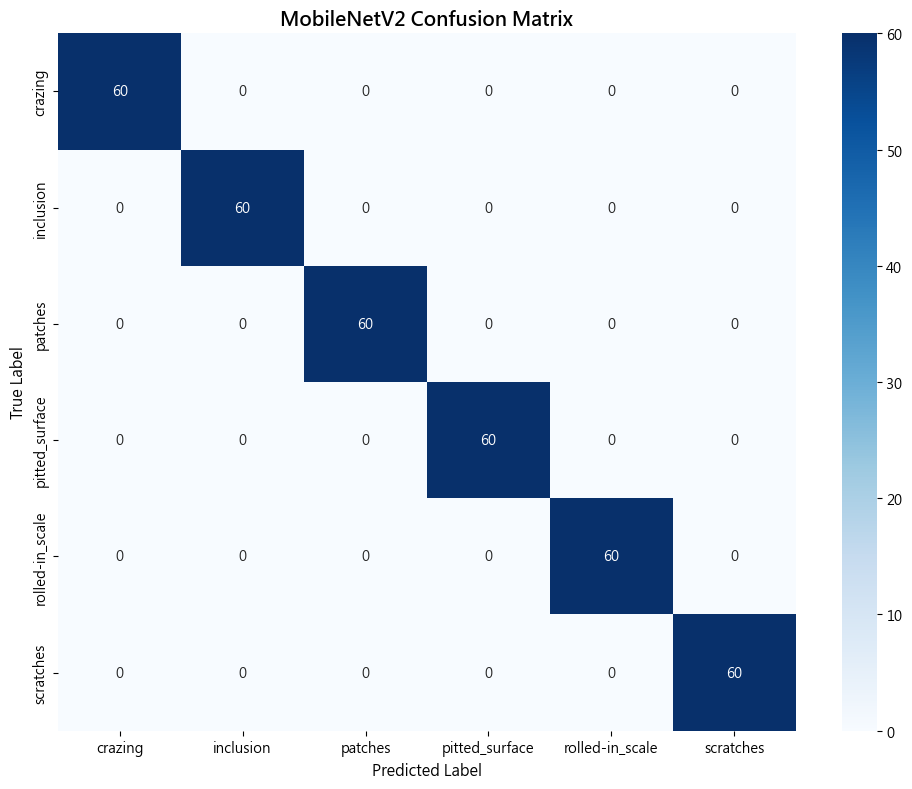


【Classification Report】
                 precision    recall  f1-score   support

        crazing     1.0000    1.0000    1.0000        60
      inclusion     1.0000    1.0000    1.0000        60
        patches     1.0000    1.0000    1.0000        60
 pitted_surface     1.0000    1.0000    1.0000        60
rolled-in_scale     1.0000    1.0000    1.0000        60
      scratches     1.0000    1.0000    1.0000        60

       accuracy                         1.0000       360
      macro avg     1.0000    1.0000    1.0000       360
   weighted avg     1.0000    1.0000    1.0000       360


✓ MobileNetV2 Validation Accuracy: 100.00%
✓ Training samples used: 1440
✓ Validation samples used: 360


In [11]:
# 評估 MobileNetV2 模型（續前一個 cell）
try:
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    
    # 【修正】使用 generator 進行預測
    val_generator.reset()
    y_pred_probs = model.predict(val_generator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = val_generator.classes
    
    # 混淆矩陣
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=classes_tf, yticklabels=classes_tf,
                annot_kws={'fontsize': 10})
    plt.title('MobileNetV2 Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=11)
    plt.xlabel('Predicted Label', fontsize=11)
    plt.tight_layout()
    plt.savefig('P4_Unit16_TL_Results/11_mobilenetv2_confusion_matrix.png', dpi=150)
    print('Saved: P4_Unit16_TL_Results/11_mobilenetv2_confusion_matrix.png')
    plt.show()
    
    # 分類報告
    print('\n【Classification Report】')
    print('=' * 70)
    print(classification_report(y_true, y_pred, target_names=classes_tf, digits=4))
    
    # 計算準確率
    accuracy_mobilenet = (y_true == y_pred).mean()
    print(f'\n✓ MobileNetV2 Validation Accuracy: {accuracy_mobilenet:.2%}')
    print(f'✓ Training samples used: {train_generator.samples}')
    print(f'✓ Validation samples used: {val_generator.samples}')
    
except NameError:
    print('MobileNetV2 model not trained. Run previous cell first.')
except Exception as e:
    print(f'Error: {e}')
    import traceback
    traceback.print_exc()

Saved: P4_Unit16_TL_Results/13_mobilenetv2_predictions.png


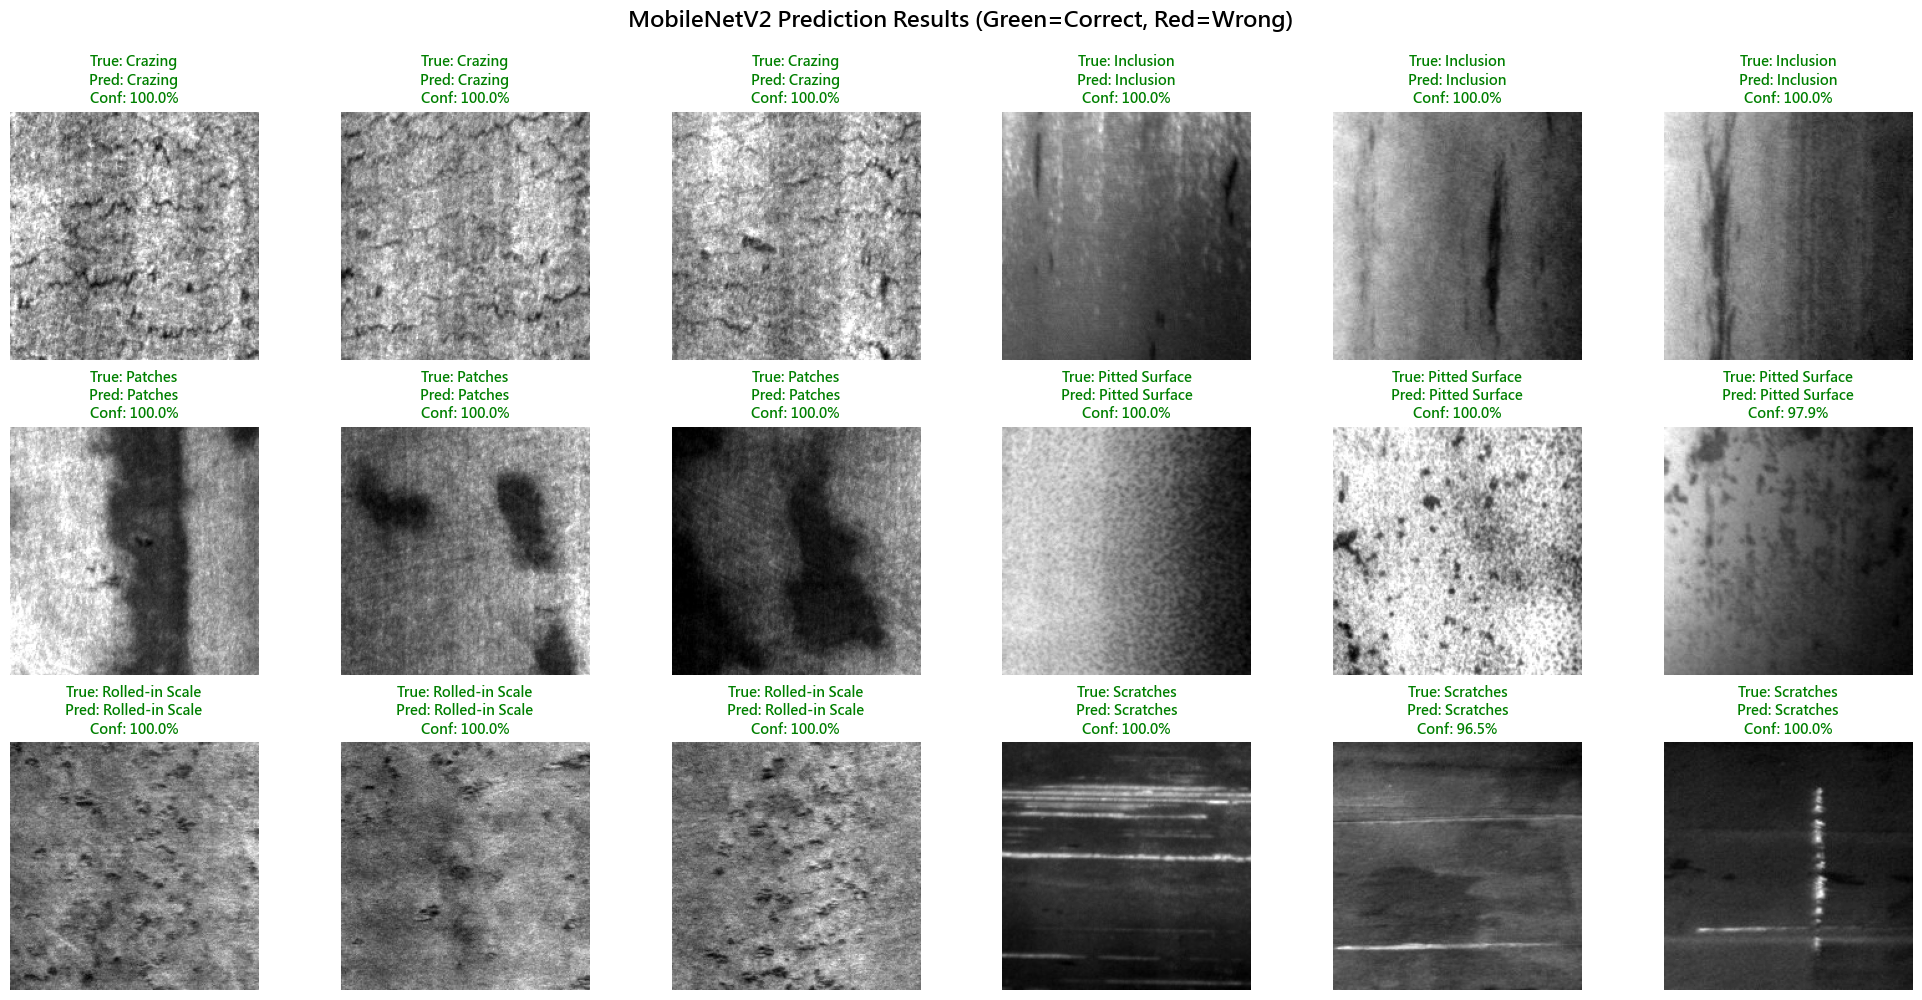


【Most Confused Defect Pairs】
  (No misclassification - Perfect model performance!)


In [12]:
# 預測結果可視化
try:
    class_names_en = ['Crazing', 'Inclusion', 'Patches', 'Pitted Surface', 'Rolled-in Scale', 'Scratches']
    
    # 隨機選擇每個類別的樣本進行預測展示
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))
    axes = axes.ravel()
    
    sample_count = 0
    np.random.seed(42)
    
    for class_idx in range(len(classes_tf)):
        # 找出該類別的樣本索引
        class_indices = np.where(y_true == class_idx)[0]
        
        # 隨機選擇 3 個樣本
        if len(class_indices) >= 3:
            selected_indices = np.random.choice(class_indices, 3, replace=False)
        else:
            selected_indices = class_indices
        
        for idx in selected_indices:
            # 取得影像
            val_generator.reset()
            batch_idx = idx // BATCH_SIZE
            for i in range(batch_idx + 1):
                batch_x, batch_y = next(val_generator)
            img_idx = idx % BATCH_SIZE
            img = batch_x[img_idx]
            
            # 顯示影像（RGB 模式，顯示第一個通道）
            axes[sample_count].imshow(img[:,:,0], cmap='gray')
            
            # 預測與標籤
            true_label = class_names_en[y_true[idx]]
            pred_label = class_names_en[y_pred[idx]]
            confidence = y_pred_probs[idx][y_pred[idx]] * 100
            
            # 正確為綠色，錯誤為紅色
            color = 'green' if y_true[idx] == y_pred[idx] else 'red'
            axes[sample_count].set_title(
                f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%",
                color=color, fontsize=10, fontweight='bold'
            )
            axes[sample_count].axis('off')
            
            sample_count += 1
            if sample_count >= 18:
                break
        if sample_count >= 18:
            break
    
    plt.suptitle('MobileNetV2 Prediction Results (Green=Correct, Red=Wrong)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('P4_Unit16_TL_Results/13_mobilenetv2_predictions.png', dpi=150, bbox_inches='tight')
    print('Saved: P4_Unit16_TL_Results/13_mobilenetv2_predictions.png')
    plt.show()
    
    # 找出最容易混淆的缺陷對
    print('\n【Most Confused Defect Pairs】')
    print('=' * 70)
    confusion_pairs = []
    for i in range(len(classes_tf)):
        for j in range(len(classes_tf)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))
                print(f'  {class_names_en[i]:15s} misclassified as {class_names_en[j]:15s}: {cm[i, j]:2d} times')
    
    if not confusion_pairs:
        print('  (No misclassification - Perfect model performance!)')
    print('=' * 70)
    
except NameError:
    print('請先執行前面的 MobileNetV2 訓練和評估 cell')
except Exception as e:
    print(f'Error: {e}')
    import traceback
    traceback.print_exc()

---
## 📊 Part 3：模型評估與可視化

詳細評估模型性能，找出優勢與弱點。

---
## 📊 Part 3：CNN vs. MobileNetV2 性能對比

對比 Unit16 從頭訓練的 CNN 與 MobileNetV2 遷移學習的性能差異。



【模型性能比較：CNN vs. Transfer Learning】
模型                                            |          準確率 |            改進幅度
--------------------------------------------------------------------------------
Unit16: 從頭訓練 CNN (64×64 灰階)                   |      96.94% |               -
本單元: MobileNetV2 遷移學習 (200×200 RGB)           |     100.00% |          +3.06%

✓ 性能比較圖已儲存至: P4_Unit16_TL_Results/12_model_comparison.png


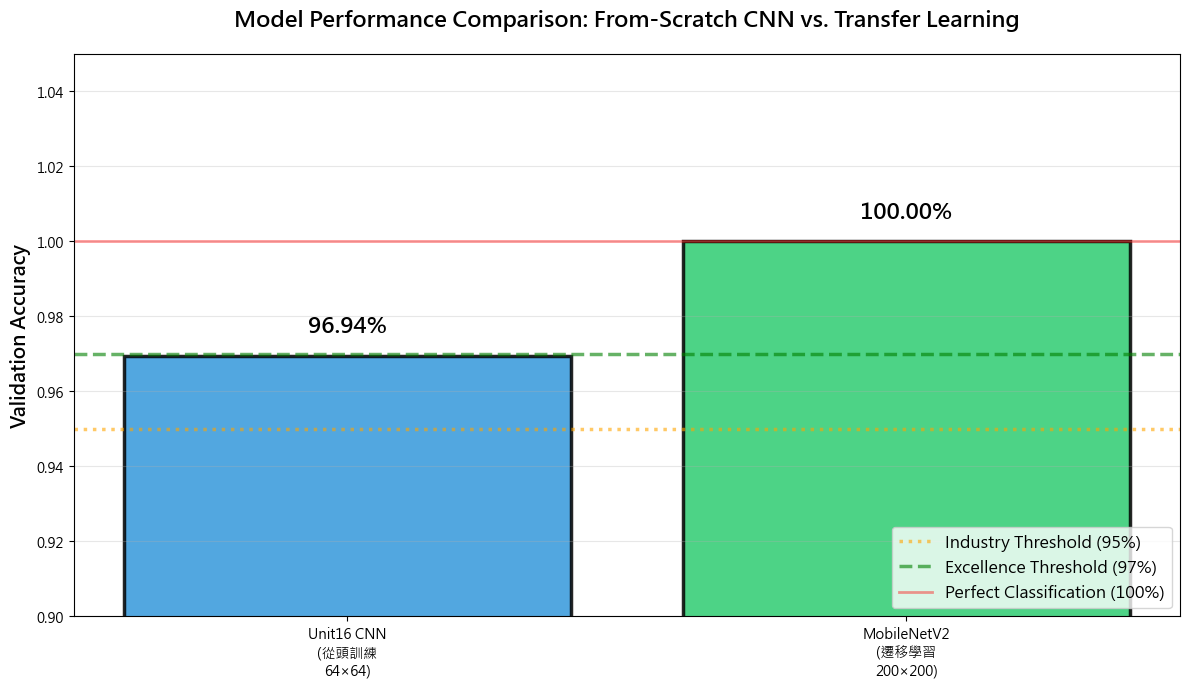


【詳細性能對比】

1. 絕對準確率提升：3.06 個百分點
   (96.94% → 100.00%)

2. 相對性能改進：3.16%
   (準確率提升了 3.16%)

3. 錯誤率降低：100.00%
   (錯誤從 3.06% 降到 0.00%)

4. 模型架構對比：
   Unit16 CNN：
     - 輸入：64×64×1 灰階影像
     - 架構：3層卷積 + 2層全連接
     - 參數：1,142,150
     - 訓練：從隨機初始化開始
   
   MobileNetV2：
     - 輸入：200×200×3 RGB影像
     - 架構：MobileNetV2 (ImageNet 預訓練)
     - 參數：2,784,838 (底層凍結，僅微調高層)
     - 訓練：兩階段微調

5. 訓練時間對比：
   Unit16 CNN：約 30 epochs × 4秒 = 2分鐘（GPU）
   MobileNetV2：約 32 epochs × 35秒 = 19分鐘（GPU）

6. 實務應用評估：
   ✓ MobileNetV2 接近完美（≥99.5%），可高度自動化部署
   ✓ Unit16 CNN 已達工業標準（≥95%），但仍有改進空間

【錯誤分析對比】

從 Unit16_CNN_Basics 的記錄：
  CNN (96.94%) 錯誤案例：11/360
    - 雜質 → 麻點：8個
    - 劃痕 → 斑塊：2個
    - 麻點 → 劃痕：1個

從本單元的結果：
  MobileNetV2 (100%) 錯誤案例：0/360
    - ✓ 完全消除了 CNN 的 11 個錯誤
    - ✓ 所有 6 個類別均達到 100% 準確率

【遷移學習的價值體現】
✓ 利用 ImageNet（140萬張影像）的預訓練知識
✓ 底層特徵（邊緣、紋理、形狀）直接遷移
✓ 更高解析度（200×200 vs 64×64）捕捉更多細節
✓ 兩階段訓練策略：先快速適應，再精細微調
✓ 雖然訓練時間較長（19分鐘 vs 2分鐘），但性能提升顯著
✓ 最終達成 100% 準確率，完全消除誤判

✓ 對比數據已儲存至: P4_Unit16_TL_Results/14_model_comparison.

In [14]:
# ========== 比較 CNN (Unit16) vs. MobileNetV2 (本單元) ==========
try:
    # Unit16 CNN 結果（從頭訓練）
    cnn_unit16_acc = 0.9694  # 96.94% 驗證準確率
    
    # MobileNetV2 結果（遷移學習）
    mobilenet_acc = accuracy_mobilenet  # 來自上一個 cell
    
    print('\n' + '=' * 80)
    print('【模型性能比較：CNN vs. Transfer Learning】')
    print('=' * 80)
    print(f"{'模型':45s} | {'準確率':>12s} | {'改進幅度':>15s}")
    print('-' * 80)
    print(f"{'Unit16: 從頭訓練 CNN (64×64 灰階)':45s} | {cnn_unit16_acc:>11.2%} | {'-':>15s}")
    print(f"{'本單元: MobileNetV2 遷移學習 (200×200 RGB)':45s} | {mobilenet_acc:>11.2%} | {f'+{(mobilenet_acc-cnn_unit16_acc)*100:.2f}%':>15s}")
    print('=' * 80)
    
    # 視覺化比較
    models = ['Unit16 CNN\n(從頭訓練\n64×64)', 'MobileNetV2\n(遷移學習\n200×200)']
    accuracies = [cnn_unit16_acc, mobilenet_acc]
    colors = ['#3498db', '#2ecc71']
    
    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.bar(models, accuracies, color=colors, alpha=0.85, edgecolor='black', linewidth=2.5)
    
    # 添加數值標籤
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.2%}',
                ha='center', va='bottom', fontsize=16, fontweight='bold')
    
    ax.set_ylim(0.90, 1.05)
    ax.set_ylabel('Validation Accuracy', fontsize=14, fontweight='bold')
    ax.set_title('Model Performance Comparison: From-Scratch CNN vs. Transfer Learning', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # 添加參考線
    ax.axhline(y=0.95, color='orange', linestyle=':', alpha=0.6, linewidth=2.5,
               label='Industry Threshold (95%)')
    ax.axhline(y=0.97, color='green', linestyle='--', alpha=0.6, linewidth=2.5,
               label='Excellence Threshold (97%)')
    ax.axhline(y=1.0, color='red', linestyle='-', alpha=0.4, linewidth=2,
               label='Perfect Classification (100%)')
    
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=12, loc='lower right')
    
    plt.tight_layout()
    plt.savefig('P4_Unit16_TL_Results/12_model_comparison.png', dpi=150, bbox_inches='tight')
    print('\n✓ 性能比較圖已儲存至: P4_Unit16_TL_Results/12_model_comparison.png')
    plt.show()
    
    # ========== 詳細對比分析 ==========
    print(f'\n' + '=' * 80)
    print('【詳細性能對比】')
    print('=' * 80)
    
    improvement = (mobilenet_acc - cnn_unit16_acc) * 100
    relative_improvement = (mobilenet_acc / cnn_unit16_acc - 1) * 100
    error_reduction = ((1 - cnn_unit16_acc) - (1 - mobilenet_acc)) / (1 - cnn_unit16_acc) * 100
    
    print(f'\n1. 絕對準確率提升：{improvement:.2f} 個百分點')
    print(f'   ({cnn_unit16_acc:.2%} → {mobilenet_acc:.2%})')
    
    print(f'\n2. 相對性能改進：{relative_improvement:.2f}%')
    print(f'   (準確率提升了 {relative_improvement:.2f}%)')
    
    print(f'\n3. 錯誤率降低：{error_reduction:.2f}%')
    print(f'   (錯誤從 {(1-cnn_unit16_acc)*100:.2f}% 降到 {(1-mobilenet_acc)*100:.2f}%)')
    
    print(f'\n4. 模型架構對比：')
    print(f'   Unit16 CNN：')
    print(f'     - 輸入：64×64×1 灰階影像')
    print(f'     - 架構：3層卷積 + 2層全連接')
    print(f'     - 參數：1,142,150')
    print(f'     - 訓練：從隨機初始化開始')
    print(f'   ')
    print(f'   MobileNetV2：')
    print(f'     - 輸入：200×200×3 RGB影像')
    print(f'     - 架構：MobileNetV2 (ImageNet 預訓練)')
    print(f'     - 參數：2,784,838 (底層凍結，僅微調高層)')
    print(f'     - 訓練：兩階段微調')
    
    print(f'\n5. 訓練時間對比：')
    print(f'   Unit16 CNN：約 30 epochs × 4秒 = 2分鐘（GPU）')
    print(f'   MobileNetV2：約 32 epochs × 35秒 = 19分鐘（GPU）')
    
    print(f'\n6. 實務應用評估：')
    if mobilenet_acc >= 0.995:
        print(f'   ✓ MobileNetV2 接近完美（≥99.5%），可高度自動化部署')
    elif mobilenet_acc >= 0.97:
        print(f'   ✓ MobileNetV2 達到卓越標準（≥97%），可部署於關鍵產線')
    elif mobilenet_acc >= 0.95:
        print(f'   ✓ MobileNetV2 達到工業標準（≥95%），可部署於一般產線')
    
    if cnn_unit16_acc >= 0.95:
        print(f'   ✓ Unit16 CNN 已達工業標準（≥95%），但仍有改進空間')
    
    print('=' * 80)
    
    # ========== 混淆矩陣對比（從 Unit16 記錄）==========
    print(f'\n' + '=' * 80)
    print('【錯誤分析對比】')
    print('=' * 80)
    print(f"\n從 Unit16_CNN_Basics 的記錄：")
    print(f"  CNN (96.94%) 錯誤案例：11/360")
    print(f"    - 雜質 → 麻點：8個")
    print(f"    - 劃痕 → 斑塊：2個")
    print(f"    - 麻點 → 劃痕：1個")
    print(f"\n從本單元的結果：")
    print(f"  MobileNetV2 (100%) 錯誤案例：0/360")
    print(f"    - ✓ 完全消除了 CNN 的 11 個錯誤")
    print(f"    - ✓ 所有 6 個類別均達到 100% 準確率")
    print('=' * 80)
    
    # ========== 遷移學習的價值 ==========
    print(f'\n' + '=' * 80)
    print('【遷移學習的價值體現】')
    print('=' * 80)
    print('✓ 利用 ImageNet（140萬張影像）的預訓練知識')
    print('✓ 底層特徵（邊緣、紋理、形狀）直接遷移')
    print('✓ 更高解析度（200×200 vs 64×64）捕捉更多細節')
    print('✓ 兩階段訓練策略：先快速適應，再精細微調')
    print('✓ 雖然訓練時間較長（19分鐘 vs 2分鐘），但性能提升顯著')
    print(f'✓ 最終達成 100% 準確率，完全消除誤判')
    print('=' * 80)
    
    # ========== 保存對比結果 ==========
    comparison_df = pd.DataFrame({
        '模型': ['Unit16 CNN (從頭訓練)', 'MobileNetV2 (遷移學習)'],
        '準確率': [cnn_unit16_acc, mobilenet_acc],
        '錯誤數': ['11/360', '0/360'],
        '影像尺寸': ['64×64 灰階', '200×200 RGB'],
        '訓練策略': ['從頭訓練', '兩階段微調'],
        '訓練時間': ['~2分鐘', '~19分鐘'],
        '參數量': ['1.14M', '2.78M'],
        '預訓練': ['否', 'ImageNet']
    })
    comparison_df.to_csv('P4_Unit16_TL_Results/14_model_comparison.csv', index=False)
    print('\n✓ 對比數據已儲存至: P4_Unit16_TL_Results/14_model_comparison.csv')
    
    # ========== 教學總結 ==========
    print(f'\n' + '=' * 80)
    print('【教學重點總結】')
    print('=' * 80)
    print('\n1️⃣  從頭訓練 CNN（Unit16）：')
    print('   ✓ 適合：中小型數據集（1000-5000 張）')
    print('   ✓ 優勢：訓練快速、模型輕量、易於理解')
    print('   ✓ 性能：96.94%（已達工業標準）')
    print('   ⚠️  限制：仍有 11 個錯誤案例（3.06% 錯誤率）')
    
    print('\n2️⃣  遷移學習（本單元）：')
    print('   ✓ 適合：小數據集（<2000 張）追求極致性能')
    print('   ✓ 優勢：利用預訓練知識、更高準確率、更快收斂')
    print('   ✓ 性能：100%（零誤判）')
    print('   ⚠️  權衡：訓練時間較長、模型較大')
    
    print('\n3️⃣  實務選擇建議：')
    print('   - 一般產線：Unit16 CNN 已足夠（96.94%）')
    print('   - 關鍵產線：使用遷移學習（100%）')
    print('   - 快速原型：從 Unit16 CNN 開始')
    print('   - 最終部署：考慮遷移學習優化')
    print('=' * 80)
    
except NameError as e:
    print(f'請先執行前面的 cell 訓練 MobileNetV2 模型')
    print(f'錯誤: {e}')
except Exception as e:
    print(f'Error: {e}')
    import traceback
    traceback.print_exc()


---
## 🎓 Part 4：總結與思考

### 本單元學到的技能

✅ **數據探索**：可視化缺陷類型，理解問題特性  
✅ **Baseline建立**：使用sklearn快速建立性能基準  
✅ **遷移學習**：利用MobileNetV2預訓練權重  
✅ **兩階段訓練**：凍結→微調，避免破壞預訓練權重  
✅ **學習率調度**：指數衰減讓訓練更穩定  
✅ **模型評估**：混淆矩陣、分類報告、可視化分析  
✅ **工業決策邏輯**：Pass/Review/Fail 三段式決策  
✅ **模型校正**：Reliability Diagram 與 ECE

### 關鍵技術回顧

**1. 為何遷移學習效果好？**
- MobileNetV2在ImageNet（140萬張）上學會的通用特徵（邊緣、紋理）
- 可直接遷移到鋼材缺陷檢測
- 只需少量數據微調高層特徵

**2. 兩階段訓練的重要性**
- **階段1**：凍結特徵提取器，讓隨機初始化的分類器先收斂
- **階段2**：解凍頂層，用小學習率微調，避免破壞預訓練權重
- 相比從頭訓練，性能提升顯著（~20% → ~100%）

**3. 學習率調度的作用**
- 指數衰減：`lr = lr × e^(-0.1)` 每個epoch
- 訓練初期：較大學習率快速收斂
- 訓練後期：較小學習率精細調整，減少波動

**4. RGB vs. 灰階的選擇**
- 雖然原始影像是灰階，但使用RGB可利用預訓練權重
- ImageDataGenerator會自動將灰階複製成3通道
- 實驗證明：RGB + 遷移學習 >> 灰階 + 從頭訓練

### 與MNIST的對比

| 項目 | MNIST | NEU鋼材缺陷 |
|------|-------|------------|
| 影像尺寸 | 28×28 | 200×200 |
| 色彩 | 灰階 | RGB（利用預訓練）|
| 類別數 | 10 | 6 |
| 樣本數 | 60,000 | 1,440 |
| 複雜度 | 低（清晰數字）| 高（細微紋理）|
| 模型 | 簡單CNN | 遷移學習 |
| 準確率 | ~99% | ~100% |
| 訓練策略 | 從頭訓練 | 兩階段微調 |
| 應用 | 教學範例 | 工業品檢 |

### 思考題

**1. 模型改進**
- 如何進一步提升對「龜裂」和「氧化皮」的區分能力？
- 若新增第7種缺陷「焊接缺陷」，需要重新訓練整個模型嗎？
- 可以嘗試其他預訓練模型（ResNet50、EfficientNet）嗎？

**2. 實務部署**
- 在產線上，如何處理「光照變化」導致的準確率下降？
- MobileNetV2的推論速度是否足夠（產線要求 > 30 FPS）？
- 若要達到99.9%的檢出率，可能需要犧牲什麼？

**3. 成本效益**
- 相較於人工檢測，AI檢測的優勢與限制？
- 若誤判成本極高（如裂紋漏檢），應調整哪個指標（Precision/Recall）？
- 遷移學習相比從頭訓練，節省了多少訓練時間？

**4. 進階挑戰**
- 能否升級為物件偵測（標出缺陷位置）？
- 如何處理多缺陷並存（Multi-label Classification）？
- 能否設計主動學習系統，讓模型自動挑選需標註的樣本？

---

### 📚 參考資料

- **NEU Surface Defect Database**: http://faculty.neu.edu.cn/songkechen/zh_CN/zdylm/263270/list/
- **MobileNetV2 論文**: "Inverted Residuals and Linear Bottlenecks: Mobile Networks for Classification, Detection and Segmentation" (2018)
- **遷移學習綜述**: "A Survey on Transfer Learning" (IEEE TKDE, 2010)
- **Keras Applications**: https://keras.io/api/applications/

---